# Membrane Model

A 2D model model with a shell in tube geometry. Counter-current plug flow with radial diffusion. Between the inner retentate side and the outside annular permeate side there is a membrane where a substance permeates.
The purpose of this example is to demonstrate how to couple submodels, either via explicit coupling, or fully implicit.

On both sides the governing equation is:

$\frac{\partial c}{\partial t} + \mathrm{div}_z (v \, c) - \mathrm{div}_r (D \, \mathrm{div}_r(c))  = 0$

On the retentate and permeate of the membrane we use Sieverts law as interface conditions:

$D \frac{\partial c_\mathrm{ret}}{\partial n} = P \, (\sqrt{p_\mathrm{perm}} - \sqrt{p_\mathrm{ret}})$, and $\frac{R_\mathrm{perm}}{R_\mathrm{ret}} D \frac{\partial c_\mathrm{perm}}{\partial n} =  P \, (\sqrt{p_\mathrm{ret}} - \sqrt{p_\mathrm{perm}})$.

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse.linalg as sla
from pymrm import construct_grad, construct_div, update_csc_array_indices, construct_convflux_upwind, construct_interface_matrices, NumJac

L = 0.2
D = 1e-4
P = 5e-6
Rg = 8.314
T = 500
c_in = 1e4/(Rg*T)
v_ret = 1e-2
v_perm = 5e-2
R_ret = 5e-3
R_perm = R_ret + 5e-4
R_out = 7e-3

num_z = 100
num_r_perm = 10
num_r_ret = 10
num_iter = 20
tol = 1e-7

dz = L/num_z
z_f = np.linspace(0, L, num_z+1)
z_c = 0.5*(z_f[1:] + z_f[:-1])
r_f_ret = np.linspace(0, R_ret, num_r_ret+1)
r_c_ret = 0.5*(r_f_ret[1:] + r_f_ret[:-1])
r_f_perm = np.linspace(R_perm, R_out, num_r_perm+1)
r_c_perm = 0.5*(r_f_perm[1:] + r_f_perm[:-1])

bc_neumann = {'a': 1, 'b': 0, 'd': 0}
bc_dirichlet = {'a': 0, 'b': 1, 'd': 1}

shape_ret = (num_z, num_r_ret)
shape_perm = (num_z, num_r_perm)
shape_d = (num_z, 1)

div_ret_mat_z = construct_div(shape_ret, z_f, axis=0, nu=0)
div_ret_mat_r = construct_div(shape_ret, r_f_ret, axis=1, nu=1)
div_perm_mat_z = construct_div(shape_perm, z_f, axis=0, nu=0)
div_perm_mat_r = construct_div(shape_perm, r_f_perm, axis=1, nu=1)

conv_ret_mat, conv_ret_bc = construct_convflux_upwind(shape_ret, z_f, z_c, (bc_dirichlet, bc_neumann), v_ret, axis = 0)
conv_ret_bc *= c_in
conv_perm_mat, conv_perm_bc = construct_convflux_upwind(shape_perm, z_f, z_c, (bc_neumann, bc_dirichlet), -v_perm, axis = 0)
conv_perm_bc *= 0.0


In [2]:
from pymrm import compute_boundary_values

def print_balances():
    c_in_ret, _, c_out_ret, _  = compute_boundary_values(c_ret, z_f, z_c, ({'a':0, 'b': 1, 'd':c_in}, bc_neumann), axis=0)
    c_out_perm, _, c_in_perm, _  = compute_boundary_values(c_perm, z_f, z_c, (bc_neumann, {'a':0, 'b': 1, 'd':0}), axis=0)
    dA_r_ret = np.pi*(r_f_ret[1:]**2 - r_f_ret[:-1]**2).reshape((1,-1))
    dA_r_perm = np.pi*(r_f_perm[1:]**2 - r_f_perm[:-1]**2).reshape((1,-1))

    _, _, _, grad_mem_ret  = compute_boundary_values(c_ret, r_f_ret, r_c_ret, (bc_neumann, {'a':0, 'b': 1, 'd':c_b_ret}), axis=1)
    _ , grad_mem_perm, _, _  = compute_boundary_values(c_perm, r_f_perm, r_c_perm, ({'a':0, 'b': 1, 'd':c_b_perm}, bc_neumann), axis=1)
    dA_z_ret = 2*np.pi*R_ret*(z_f[1:] - z_f[:-1]).reshape((-1,1))
    dA_z_perm = 2*np.pi*R_perm*(z_f[1:] - z_f[:-1]).reshape((-1,1))

    flow_in_ret = v_ret*np.sum(c_in_ret*dA_r_ret, axis=1).reshape(())
    flow_out_ret = v_ret*np.sum(c_out_ret*dA_r_ret, axis=1).reshape(())
    flow_in_perm = v_perm*np.sum(c_in_perm*dA_r_perm, axis=1).reshape(())
    flow_out_perm = v_perm*np.sum(c_out_perm*dA_r_perm, axis=1).reshape(())
    flow_mem_ret = -D*np.sum(grad_mem_ret*dA_z_ret, axis=0).reshape(())
    flow_mem_perm = -D*np.sum(grad_mem_perm*dA_z_perm, axis=0).reshape(())

    print(f"retentate side: inlet molar flow = {flow_in_ret:.5e}, membrane molar flow out = {flow_mem_ret:.5e}, outlet molar flow = {flow_out_ret:.5e}")
    print(f"retentate balance: {flow_in_ret - flow_mem_ret - flow_out_ret:.5e}")
    print(f"permeate side:  inlet molar flow = {flow_in_perm:.5e}, membrane molar flow in  = {flow_mem_perm:.5e}, outlet molar flow = {flow_out_perm:.5e}")
    print(f"permeate balance: {flow_in_perm + flow_mem_perm - flow_out_perm:.5e}")
    print(f"overall balance: {flow_in_ret + flow_in_perm - flow_out_ret - flow_out_perm:.5e}")
  


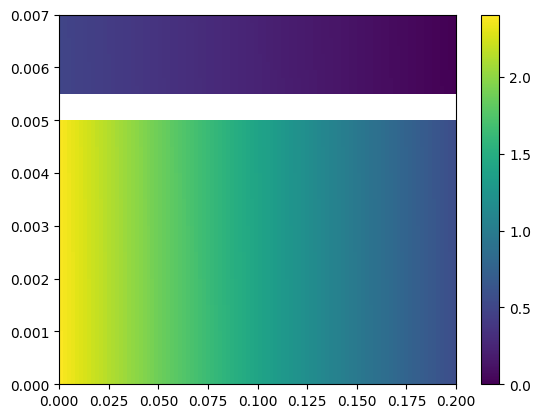

retentate side: inlet molar flow = 1.88934e-06, membrane molar flow out = 1.44650e-06, outlet molar flow = 4.42837e-07
retentate balance: -4.02605e-19
permeate side:  inlet molar flow = 0.00000e+00, membrane molar flow in  = 1.44650e-06, outlet molar flow = 1.44650e-06
permeate balance: 5.32784e-19
overall balance: -6.01182e-19


In [3]:
# Implicit coupling

c_all = np.zeros((num_z, num_r_ret + num_r_perm))
c_ret = c_all[:, :num_r_ret]
c_perm = c_all[:, num_r_ret:]
c_vect = c_all.reshape((-1,1))

shape_ret = c_ret.shape
shape_perm = c_perm.shape
shape_d = (num_z, 1)

grad_ret_mat, _, grad_ret_bc = construct_grad(shape_ret, r_f_ret, r_c_ret, bc = (bc_neumann, bc_dirichlet), axis = 1, shapes_d = (None, shape_d))
jac_ret_mat = div_ret_mat_z @ conv_ret_mat - D*div_ret_mat_r @ grad_ret_mat
g_ret_bc  = div_ret_mat_z @ conv_ret_bc
jac_ret_dirichlet_bc  = -D*div_ret_mat_r @ grad_ret_bc
jac_ret_dirichlet_bc = update_csc_array_indices(jac_ret_dirichlet_bc, (shape_ret, None), (c_all.shape, None), offset=None)
jac_ret_mat = update_csc_array_indices(jac_ret_mat, shape_ret, c_all.shape, offset=None)
g_ret_bc = update_csc_array_indices(g_ret_bc, (shape_ret, None), (c_all.shape, None), offset=None)

grad_perm_mat, grad_perm_bc, _ = construct_grad(shape_perm, r_f_perm, r_c_perm, bc=(bc_dirichlet, bc_neumann), axis = 1, shapes_d = (shape_d, None))
jac_perm_mat = div_perm_mat_z @ conv_perm_mat - D*div_perm_mat_r @ grad_perm_mat
g_perm_bc  = div_perm_mat_z @ conv_perm_bc*0
jac_perm_dirichlet_bc  = -D*div_perm_mat_r @ grad_perm_bc
jac_perm_dirichlet_bc = update_csc_array_indices(jac_perm_dirichlet_bc, (shape_perm, None), (c_all.shape, None), offset=((0,shape_ret[1]),None))
jac_perm_mat = update_csc_array_indices(jac_perm_mat, shape_perm, c_all.shape, offset=(0,shape_ret[1]))
g_perm_bc = update_csc_array_indices(g_perm_bc, (shape_perm, None), (c_all.shape, None), offset=((0,shape_ret[1]),None))

jac_decoupled = jac_ret_mat + jac_perm_mat

# interface conditions:
ic_1_neumann = {'a':(D,0), 'd':P}
ic_2_neumann = {'a':(0,R_perm/R_ret*D), 'd':-P}
interf_mat_ret_neumann, interf_mat_ret_neumann_bc_0, interf_mat_ret_neumann_bc_1, interf_mat_perm_neumann, interf_mat_perm_neumann_bc_0, interf_mat_perm_neumann_bc_1 = construct_interface_matrices((shape_ret, shape_perm), (r_f_ret, r_f_perm), ic=(ic_1_neumann, ic_2_neumann), axis=1, shapes_d=(shape_d, shape_d))
jac_ret_ic_neumann = jac_ret_dirichlet_bc @ interf_mat_ret_neumann
jac_perm_ic_neumann = jac_perm_dirichlet_bc @ interf_mat_perm_neumann
interf_mat_ret_neumann_bc = interf_mat_ret_neumann_bc_0 + interf_mat_ret_neumann_bc_1
jac_ret_bc_neumann = jac_ret_dirichlet_bc @ interf_mat_ret_neumann_bc
interf_mat_perm_neumann_bc = interf_mat_perm_neumann_bc_0 + interf_mat_perm_neumann_bc_1
jac_perm_bc_neumann = jac_perm_dirichlet_bc @ interf_mat_perm_neumann_bc
jac_g = jac_decoupled + jac_ret_ic_neumann + jac_perm_ic_neumann
jac_g_ic = jac_ret_bc_neumann + jac_perm_bc_neumann

def driving_force(c_b, eps=0.1):
    return Rg*T*c_b / np.sqrt(np.abs(Rg*T*c_b) + eps)

numjac = NumJac(shape=(*shape_d, 1))

c_b_ret = np.zeros(shape_d)
c_b_perm = np.zeros(shape_d)
c_b_ret_vect = c_b_ret.reshape((-1,1))
c_b_perm_vect = c_b_perm.reshape((-1,1))

# Newton-Raphson:
norm = 1.0
for i in range(num_iter):
    g_d_ret, jac_b_ret = numjac(driving_force, c_b_ret)
    g_d_perm, jac_b_perm = numjac(driving_force, c_b_perm)
    g = g_ret_bc + g_perm_bc + jac_g @ c_vect + jac_g_ic @ (g_d_perm - g_d_ret).reshape((-1,1))
    norm = np.linalg.norm(g)
    b_vect_ret = jac_b_ret.data.reshape(shape_d)
    b_vect_perm = jac_b_perm.data.reshape(shape_d)
    ic_1 = {'a':(D,0), 'b':(P*b_vect_ret,-P*b_vect_perm)}
    ic_2 = {'a':(0,R_perm/R_ret*D), 'b':(-P*b_vect_ret,P*b_vect_perm)}
    interf_mat_ret, _, interf_mat_perm, _ = construct_interface_matrices((shape_ret, shape_perm), (r_f_ret, r_f_perm), ic=(ic_1, ic_2), axis=1)
    jac_ret_ic = jac_ret_dirichlet_bc @ interf_mat_ret
    jac_perm_ic = jac_perm_dirichlet_bc @ interf_mat_perm
    jac_coupled = jac_decoupled + jac_ret_ic + jac_perm_ic
    
    dc = -sla.spsolve(jac_coupled, g).reshape((-1,1))    
    c_vect[:] = c_vect + dc
    
    c_b_ret_vect[:] = c_b_ret_vect + interf_mat_ret @ dc
    c_b_perm_vect[:] = c_b_perm_vect + interf_mat_perm @ dc
    d = (driving_force(c_b_perm) - driving_force(c_b_ret)).reshape((-1,1))
    c_b_ret_vect[:] = interf_mat_ret_neumann @ c_vect + interf_mat_ret_neumann_bc @ d # here is an issue
    c_b_perm_vect[:] = interf_mat_perm_neumann @ c_vect + interf_mat_perm_neumann_bc @ d
    if norm < tol:
        break

plt.pcolormesh(z_f, r_f_ret, c_ret.transpose(), shading='flat', cmap='viridis', vmin=0, vmax=c_in)
plt.pcolormesh(z_f, r_f_perm, c_perm.transpose(), shading='flat', cmap='viridis', vmin=0, vmax=c_in)
plt.colorbar()
plt.show()

print_balances()
